# Simple DQN on Keras
The DQN Algorithm solves the issues related to the function approximations with Neural Networks:
* Bootstrap issue (Estimation with an estimation)
* Uncorrelate samples of experiences to facilitate Gradient Descent

### Loss Function
We can use as loss function the Mean Squared error between the model prediction of the Q value and a target calculated with the Bellman Equation
![alt text](imgs/loss_func_aprox.png "Game")

### Q Learning Update equation
The update equation will provides us the target for our loss function.
$$Q(s_t,a_t) \leftarrow Q(s_t,a_t) + \alpha \big[r_t + \gamma \max\limits_{a} Q(s_{t+1},a_{t+1}) - Q(s_t,a_t)\big]$$
```python
Q_target[action] = reward + torch.mul(maxQ1.detach(), gamma)
```

![alt text](imgs/DQN.png "DQN")

<img src="imgs/dqn_algo.png" alt="Algorithm DQN" style="width: 600px;"/>

### Act Greedy
$\pi^*(s) = \arg\!\max_a \ Q^*(s, a)$

### Target Error
$\delta = Q(s, a) - (r + \gamma \max_a Q(s', a))$

### References
* https://medium.com/mlreview/speeding-up-dqn-on-pytorch-solving-pong-in-30-minutes-81a1bd2dff55
* https://stackoverflow.com/questions/51960225/dqn-average-reward-decrease-after-training-for-a-period-of-time
* https://medium.freecodecamp.org/improvements-in-deep-q-learning-dueling-double-dqn-prioritized-experience-replay-and-fixed-58b130cc5682
* https://towardsdatascience.com/atari-reinforcement-learning-in-depth-part-1-ddqn-ceaa762a546f
* https://pytorch.org/tutorials/intermediate/reinforcement_q_learning.html
* https://github.com/keras-rl/keras-rl
* https://machinelearningmastery.com/reproducible-results-neural-networks-keras/
* https://stackoverflow.com/questions/17280575/pdb-ipdb-for-python-break-on-editable-condition
* https://davidhamann.de/2017/04/22/debugging-jupyter-notebooks/
* https://colab.research.google.com/gist/Tony607/7f55518ba7af13eb7e2e782b3b50a38b/tensorboard_in_notebooks.ipynb
* https://colab.research.google.com/github/tensorflow/examples/blob/master/community/en/tensorboard/tf_dev_summit_2019.ipynb

### Import Libraries

In [1]:
import gym
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import Model

from collections import deque
import matplotlib
import matplotlib.pyplot as plt
from IPython import display
from IPython.display import clear_output

import datetime

# Delete previous logs
!rm -rf ./logs/ 

# Debug
import ipdb; 

# Create the Cart-Pole game environment
env = gym.make('CartPole-v0')

## Plot function
def moving_average(a, n=3) :
    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n - 1:] / n

def plot_durations(durations_t):
    plt.figure(2)
    plt.clf()    
    plt.title('Training...')
    plt.xlabel('Episode')
    plt.ylabel('Total Rewards')
    plt.plot(durations_t)
    # Take 100 episode averages and plot them too
    if len(durations_t) >= 100:        
        plt.plot(moving_average(durations_t,20))

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.


/Users/leonardo_a/anaconda3/lib/python3.6/site-packages/gym/envs/registration.py:14: PkgResourcesDeprecationWarning: Parameters to load are deprecated.  Call .resolve and .require separately.
  result = entry_point.load(False)


### Define Hyperparameters

In [2]:
train_episodes = 600              # max number of episodes to learn from
gamma = 0.99                      # future reward discount

# Exploration parameters
explore_start = 1.0               # exploration probability at start (Pure exploratory)
explore_stop = 0.01               # minimum exploration probability
decay_rate = 0.0001               # exponential decay rate for exploration prob

# Network parameters
hidden_size = 16                  # number of units in each Q-network hidden layer
learning_rate = 0.001             # Q-network learning rate

# Memory parameters
memory_size = 10000               # memory capacity
batch_size = 32                   # experience mini-batch size
pretrain_length = batch_size*10   # number experiences to pretrain the memory

consecutive_win_threshold = 5     # Number of Consecutive wins before stop training (5) (50 to the end)
target_updates = 5

### Load Tensorboard Extensions
This plugin allows tensorboard to appear on the jupyter notebook

In [3]:
current_time = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
train_log_dir = 'logs/gradient_tape/' + current_time + '/train'
train_summary_writer = tf.summary.create_file_writer(train_log_dir)

# Load the TensorBoard notebook extension
%load_ext tensorboard.notebook
logs_base_dir = "./logs"
os.makedirs(logs_base_dir, exist_ok=True)
%tensorboard --logdir {logs_base_dir}

Reusing TensorBoard on port 6006 (pid 16481), started 3:13:37 ago. (Use '!kill 16481' to kill it.)

### Fix Random Seeds
To make the experiment reproducible, we will fix the following random seeds:
* OpenAI Gym
* Numpy
* Tensorflow

In [4]:
env.seed(0)
np.random.seed(0)
tf.random.set_seed(0)

### Define Q-Network

In [5]:
class QNetwork(Model):
    def __init__(self, env, state_size=4,
                 hidden_size=10):
        super(QNetwork, self).__init__()
        action_size = env.action_space.n
        
        self.d1 = Dense(hidden_size, activation='relu', input_dim=state_size)
        self.d2 = Dense(hidden_size, activation='relu')
        self.d3 = Dense(action_size, activation='linear')
    
    def call(self, x):
        x = self.d1(x)
        x = self.d2(x)
        return self.d3(x)
    
    def greedy_act(self, state):
        Q_values = self.call(state)
        # Act greedly
        action = np.argmax(Q_values)
        return action
    

# Initialize DQN Network
mainQ = QNetwork(env, hidden_size=hidden_size)
targetQ = QNetwork(env, hidden_size=hidden_size)
targetQ.set_weights(mainQ.get_weights()) 

# Define loss and optimizer
loss_object = tf.keras.losses.MeanSquaredError()
optimizer = tf.keras.optimizers.Adam(lr=learning_rate)

### Define Training Graph

In [6]:
@tf.function
def train_step(inputs, targets, model):
    # Record operations for automatic-differentiation
    with tf.GradientTape() as tape:
        # Apply Model and get predictions
        predictions = model(inputs)
        # Calculate Loss
        loss = loss_object(targets, predictions)
        
    # Calculate the gradient of the loss with respect to the model parameters
    gradients = tape.gradient(loss, model.trainable_variables)
    # Run optimizer
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))


### Memory Buffer

In [7]:
class Memory():
    def __init__(self, max_size=1000):
        self.buffer = deque(maxlen=max_size)

    def add(self, experience):
        self.buffer.append(experience)
    
    def __len__(self):
        return len(self.buffer)

    def sample(self, batch_size):
        idx = np.random.choice(np.arange(len(self.buffer)),
                               size=batch_size,
                               replace=False)
        return [self.buffer[ii] for ii in idx]

memory = Memory(max_size=memory_size)

### Training

In [8]:
# Initialize the simulation
state = env.reset()
rewards_per_episode = []

step = 0
num_consecutive_win = 0

# For each episodes
for i_episode in range(1, train_episodes):
    total_reward = 0
    t = 0
    # Update the target network, copying all weights and biases in DQN
    if i_episode % target_updates == 0:
        targetQ.set_weights(mainQ.get_weights()) 
        
    done = False
    # Start new episode on the environment
    env.reset()      
    
    # Run an episode to the end
    while not done:
        step += 1
     
        # Epsilon Greedy Decay
        explore_p = explore_stop + (explore_start - explore_stop)*np.exp(-decay_rate*step)
        
        # Epsilon Greedy
        if explore_p > np.random.rand():
            # Make a random action
            action = env.action_space.sample()
        else:
            # Get action from Q-network
            action = mainQ.greedy_act(np.expand_dims(state, axis=0))

        # Take action, get new state and reward
        next_state, reward, done, _ = env.step(action)        
        total_reward += reward

        # Episode finish
        if done:
            print('DONE! Episode: {}'.format(i_episode),
                  'Total reward: {}'.format(total_reward),
                  'Explore P: {:.4f}'.format(explore_p))
            
            rewards_per_episode.append(total_reward)
            # Send some stuff to tensorboard
            with train_summary_writer.as_default():
                tf.summary.scalar('total_reward', total_reward, step=i_episode)

            # Early Stop
            if total_reward >= 199:
                num_consecutive_win += 1
                print('Win...')
            else:
                num_consecutive_win = 0                
            
            if num_consecutive_win > consecutive_win_threshold:                
                break

            # Add experience to memory
            memory.add((state, action, reward, next_state, done))      
        else:
            # Add experience to memory
            memory.add((state, action, reward, next_state, done))
            state = next_state

        # Check if we have enough samples on memory to sample
        # If we don't have keep gathering expriences
        if len(memory) >= batch_size:
            # Sample experience from Replay Memory
            minibatch = memory.sample(batch_size)
        else:
            # Keep populating replay memory
            print('Populating replay buffer')
            continue
        
        # Instantiate inputs (states) and targets         
        inputs = np.zeros((batch_size, np.prod(env.observation_space.shape)))
        targets = np.zeros((batch_size, env.action_space.n))
        
        
        # Iterate on the minibatch of samples from the replay memory
        for exp_idx, (state_b, action_b, reward_b, next_state_b, done_b) in enumerate(minibatch):
            #ipdb.set_trace()
            state_b = np.expand_dims(state_b, axis=0)
            next_state_b = np.expand_dims(next_state_b, axis=0)
            inputs[exp_idx] = state_b
            
            if done_b:
                # Mark target as immediate reward (If was last experience of some episode)
                target = reward_b
            else:
                # Calculate target as TD error
                target = reward_b + gamma * np.max(targetQ(next_state_b))
            
            targets[exp_idx] = targetQ(state_b)
            targets[exp_idx][action_b] = target
        
        # Update the model (In each episode end)
        train_step(inputs, targets, mainQ)
    
    # Stop Earlier ...
    if num_consecutive_win > consecutive_win_threshold:
        print('Number of consecutive wins high, stop earlier...')
        break

Populating replay buffer
Populating replay buffer
Populating replay buffer
Populating replay buffer
Populating replay buffer
Populating replay buffer
Populating replay buffer
Populating replay buffer
Populating replay buffer
Populating replay buffer
Populating replay buffer
Populating replay buffer
DONE! Episode: 1 Total reward: 13.0 Explore P: 0.9987
Populating replay buffer
Populating replay buffer
Populating replay buffer
Populating replay buffer
Populating replay buffer
Populating replay buffer
Populating replay buffer
Populating replay buffer
Populating replay buffer
Populating replay buffer
Populating replay buffer
Populating replay buffer
Populating replay buffer
Populating replay buffer
Populating replay buffer
Populating replay buffer
Populating replay buffer
Populating replay buffer
Populating replay buffer
DONE! Episode: 2 Total reward: 22.0 Explore P: 0.9965
DONE! Episode: 3 Total reward: 20.0 Explore P: 0.9946
DONE! Episode: 4 Total reward: 22.0 Explore P: 0.9924
DONE! Epi

DONE! Episode: 136 Total reward: 46.0 Explore P: 0.6717
DONE! Episode: 137 Total reward: 47.0 Explore P: 0.6686
DONE! Episode: 138 Total reward: 27.0 Explore P: 0.6668
DONE! Episode: 139 Total reward: 37.0 Explore P: 0.6644
DONE! Episode: 140 Total reward: 81.0 Explore P: 0.6591
DONE! Episode: 141 Total reward: 88.0 Explore P: 0.6534
DONE! Episode: 142 Total reward: 81.0 Explore P: 0.6482
DONE! Episode: 143 Total reward: 27.0 Explore P: 0.6465
DONE! Episode: 144 Total reward: 19.0 Explore P: 0.6453
DONE! Episode: 145 Total reward: 160.0 Explore P: 0.6352
DONE! Episode: 146 Total reward: 106.0 Explore P: 0.6286
DONE! Episode: 147 Total reward: 121.0 Explore P: 0.6212
DONE! Episode: 148 Total reward: 136.0 Explore P: 0.6129
DONE! Episode: 149 Total reward: 80.0 Explore P: 0.6081
DONE! Episode: 150 Total reward: 61.0 Explore P: 0.6045
DONE! Episode: 151 Total reward: 15.0 Explore P: 0.6036
DONE! Episode: 152 Total reward: 17.0 Explore P: 0.6026
DONE! Episode: 153 Total reward: 95.0 Explor

### Plot Total Rewards per Episode

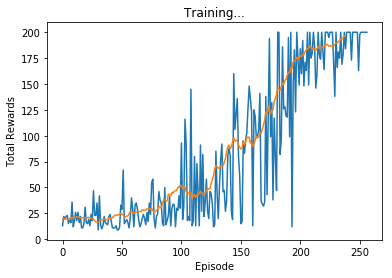

In [9]:
plot_durations(rewards_per_episode)

### Test trained Agent

In [10]:
# Reset environment
state = env.reset()
total_rewards = 0
while True:    
    # Act greedly
    action = mainQ.greedy_act(np.expand_dims(state, axis=0))

    # Uncomment to render the visual state in a window
    env.render()

    # Step through environment using chosen action
    state, reward, done, _ = env.step(action)
    total_rewards += reward
    if done:
        break
print('Total Rewards:', total_rewards)

Total Rewards: 200.0
